In [1]:
'''
This notebook experiments with the tolerance parameter of the Douglas Peucker algorithm
to find the optimal parameter
'''

'\nThis notebook experiments with the tolerance parameter of the Douglas Peucker algorithm\nto find the optimal parameter\n'

In [2]:
import geopandas as gpd
import movingpandas as mpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import warnings
import sys
warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [3]:
# read data from file
filenames = ['../data/processed/202204_points_stavanger_cleaned_200k.parquet',
             '../data/processed/202204_points_stavanger_cleaned_200k1.parquet',
             '../data/processed/202204_points_tromso_cleaned_meta_200k.parquet']
#filenames = ['../data/processed/202204_points_stavanger_cleaned_200k.parquet']

In [4]:
# Douglas Peucker tolerance parameter list
crs = 32632  # 4326 for WGS 84, 32632 for UTM 32N
if crs == 32632:
    tolerances = [5, 10, 20, 50, 75, 100, 150, 200, 300, 500, 1000, 2000, 5000]
elif crs == 4326:
    tolerances = [1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 0.01, 0.02, 0.05, 0.1]

# tolerances = [1e-3, 1e-4]
retained_fractions = {}
mean_mean_distances = {}
mean_max_distances = {}

for filename in filenames:
    # load AIS data and convert to trajectories
    gdf = gpd.read_parquet(filename)
    gdf.to_crs(crs, inplace=True)
    trajectories = mpd.TrajectoryCollection(gdf, traj_id_col='mmsi', obj_id_col='mmsi')  # convert to Trajectory Collection
    # output dataset info
    print(f'Loaded dataset: {filename}')
    print(f'AIS messages: {len(gdf)}')
    print(f'Trajectories: {len(trajectories)}')
    
    # compute fraction of retained points and distances
    n_points = []  # init: number of points retained by Douglas Peucker algorithm
    mean_distances = []  # init: mean distances between accurate trajectories and DP trajectory
    max_distances = []  # init: max distances between accurate trajectories and DP trajectory
    for tolerance in tolerances:
        # compute Douglas Peucker simplified trajectories
        simplified_trajectories = mpd.DouglasPeuckerGeneralizer(trajectories).generalize(tolerance=tolerance)
        n_points.append(len(simplified_trajectories.to_point_gdf())) # number of points retained by Douglas Peucker algorithm
        temp = simplified_trajectories.to_traj_gdf()
        mmsi_mean_distances = []
        mmsi_max_distances = []
        for mmsi in temp.mmsi.unique():
            trajectory = trajectories.get_trajectory(mmsi)
            DP_trajectory = simplified_trajectories.get_trajectory(mmsi)
            st = DP_trajectory.to_traj_gdf().geometry[0]
            t = trajectory.to_point_gdf()
            distances = []
            for point in t.geometry:
                distances.append(st.distance(point))
            distances = np.array(distances)
            mmsi_mean_distances.append(distances.mean())
            mmsi_max_distances.append(distances.max())
        mean_distances.append(np.array(mmsi_mean_distances).mean())
        max_distances.append(np.array(mmsi_max_distances).mean())
            
    # append results
    retained_fractions[filename] = np.array(n_points) / len(gdf)  # fraction of points retained by Douglas Peucker algorithm
    mean_mean_distances[filename] = np.array(mean_distances)
    mean_max_distances[filename] = np.array(max_distances)

Loaded dataset: ../data/processed/202204_points_stavanger_cleaned_200k.parquet
AIS messages: 192346
Trajectories: 249
Loaded dataset: ../data/processed/202204_points_stavanger_cleaned_200k1.parquet
AIS messages: 194684
Trajectories: 267
Loaded dataset: ../data/processed/202204_points_tromso_cleaned_meta_200k.parquet
AIS messages: 198971
Trajectories: 305


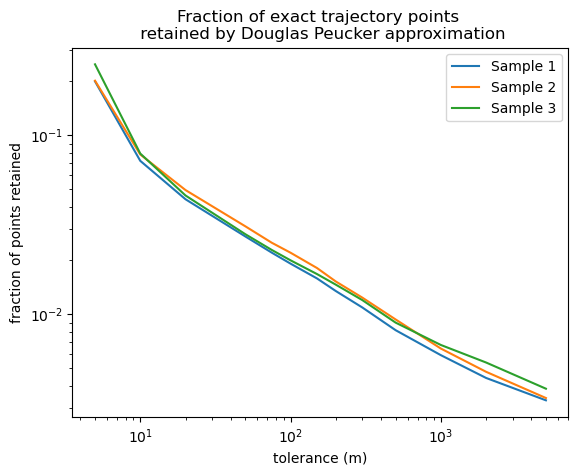

In [7]:
# plotting
plt.xscale('log')
plt.yscale('log')
for filename in filenames:
    plt.plot(tolerances, retained_fractions[filename])
plt.title('Fraction of exact trajectory points \n retained by Douglas Peucker approximation')
plt.xlabel('tolerance (m)')
plt.ylabel('fraction of points retained')
plt.legend(['Sample 1', 'Sample 2', 'Sample 3'])
plt.savefig('DP_tolerance_experiments_npoints_UTM.pdf')
plt.show()

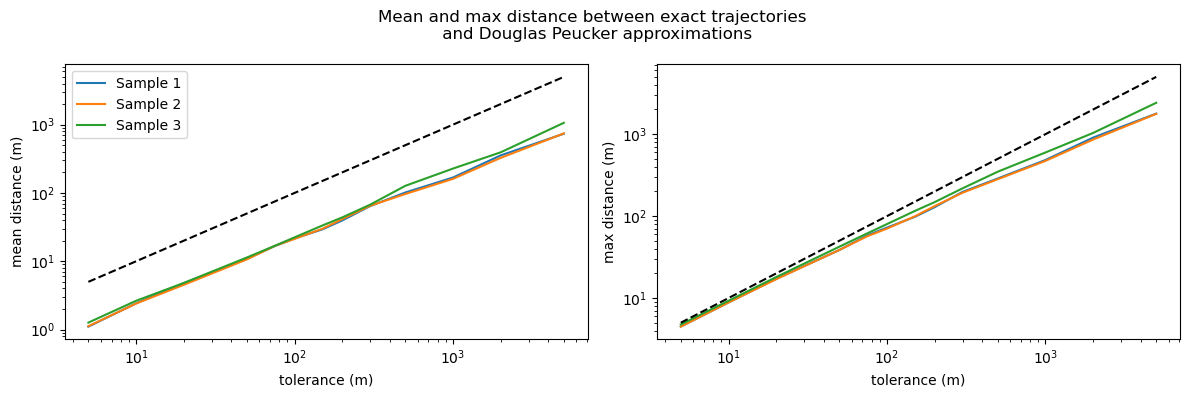

In [8]:
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Set log scale for both subplots
for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')

# Iterate through filenames and plot data
for filename in filenames:
    axs[0].plot(tolerances, mean_mean_distances[filename])
    axs[1].plot(tolerances, mean_max_distances[filename])

# Add a dashed diagonal line to both subplots
for ax in axs:
    ax.plot(tolerances, tolerances, color='k', linestyle='--')

# Set titles and labels for both subplots
fig.suptitle('Mean and max distance between exact trajectories \n and Douglas Peucker approximations')
axs[0].set_xlabel('tolerance (m)')
axs[1].set_xlabel('tolerance (m)')
axs[0].set_ylabel('mean distance (m)')
axs[1].set_ylabel('max distance (m)')

# Add a legend to the first subplot
axs[0].legend(['Sample 1', 'Sample 2', 'Sample 3'])

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('DP_tolerance_experiments_distances_UTM.pdf')

# Show the figure
plt.show()